In [1]:
import torch
import numpy as np
import cv2
from PIL import Image

In [2]:
import sys
sys.path.append('..')
from models import resnet50, densenet_121, resnet50_adv, resnet18, resnet18_seg
from utils import *

In [3]:
checkpoint_path = '../checkpoints/my_data_v4_resnet18_seg_transfer_4class/01_20_23_34_fold_0_model_best.pth.tar'
model = resnet18_seg()
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [4]:
# 添加 hook
def hook_feature(module, input, output): # input是注册层的输入 output是注册层的输出
    # print("hook input",input[0].shape)
    # features_blobs.append(output)
    features_blobs.append(output.data.cpu().numpy())
model.seg_avgpool.register_forward_hook(hook_feature)

In [5]:
# 加载真实路面数据集
from dataset import MWD, MWD_Adv
from dataset import MyData, MyDataCS, MyDataSeg
from torchvision import transforms
import matplotlib.pyplot as plt
import itertools

In [6]:
# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
image_size = 224
img_size = (576, 720)
transform = transforms.Compose([
    # transforms.Resize((image_size, image_size)),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

# dataset = MWD(root_path="G:\\weather_recognition\\groud_truth", transform=transform)
# dataset = MWD_Adv(root_path="G:\\weather_recognition\\groud_truth", transform=transform)

# train_dataset = MyData(root_path=args.train_path, transform=train_transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v2\\test\\", transform=transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_01_11\\", transform=transform)
# dataset = MyDataCS(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_01_11\\", transform=transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v4\\test\\", transform=transform)
dataset = MyDataSeg(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v4\\test\\", transform=transform)
# dataset = MyData(root_path="G:\\vscode_workspace\\Weather_Recognition\\data_split_v4\\test\\", transform=transform)

In [7]:
print(len(dataset))
print(dataset[0][0].shape)

6297
torch.Size([3, 576, 720])


In [8]:
# 绘制混淆矩阵

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def compute_cm(cm, preds, labels):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        # if t == 2 and p == 1:
        #     print('miss!')
        # cm[p, t] += 1
        cm[t, p] += 1
    return cm

In [9]:
cnt = 0
def save_misclassify(inputs, targets, preds):
    global cnt
    save_dir = "misclassify_01_26_v4_resnet18_seg_tranfer//"
    label_list = ['Cloud', 'Fog', 'Rainy', 'Snow', 'Sunny', 'Thunder']
    # label_list = ['Cloud/Sunny', 'Fog', 'Rainy', 'Snow']
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for img, t, p in zip(inputs, targets, preds):
        p = p[0]
        # print(img.shape, t, p)
        # break
        if t != p:
            img = np.transpose(img, (1, 2, 0))
            img = img * 255
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            # print(img.shape)
            img_path = save_dir + '{0}_{1}_{2}.jpg'.format(cnt, label_list[t], label_list[p]) 
            cv2.imwrite(img_path, img)
            cnt = cnt + 1


In [12]:
# 'cloudy': 0, 'haze': 1, 'rainy': 2, 'snow': 3, 'sunny': 4, 'thunder': 5
model = model.cuda()
model.eval()
top1 = AverageMeter()
data_iter = torch.utils.data.DataLoader(dataset, 4, shuffle=False)

# 混淆矩阵
# num_classes = 6
# label_list = ['Cloud', 'Fog', 'Rainy', 'Snow', 'Sunny', 'Thunder']

# num_classes = 5
# label_list = ['Cloud', 'Fog', 'Rainy', 'Snow', 'Sunny']

num_classes = 4
label_list = ['Cloud/Sunny', 'Fog', 'Rainy', 'Snow']

# 只获取预测为下雪的特征
features_blobs = []
features_labels = []

confuse_matrix = np.zeros([num_classes, num_classes])
for batch_idx, (inputs, inputs_seg, targets) in enumerate(data_iter):
    inputs, inputs_seg, targets = inputs.cuda(), inputs_seg.cuda(), targets.cuda()
    # inputs, targets = inputs.cuda(), targets.cuda()

    # outputs = model(inputs, inputs_seg)
    outputs = model(inputs, inputs_seg)

    # print(outputs)
    _, pred = outputs.topk(1, 1)
    pred_np = pred.data.cpu().numpy()
    targets_np = targets.data.cpu().numpy()
    pred_np = np.squeeze(pred_np)
    features = features_blobs.pop()
    add_flag = False
    for i in range(min(4, len(targets_np))):
        try:
            if pred_np[i] == 3:  # 雪天的 label
                features_blobs.append(np.array([features[i]]))
                features_labels.append(np.array([targets_np[i]]))
        except Exception:
            print(pred_np.shape)
            break
    # print(pred_np.shape)
    # print(targets_np.shape)
    # print(features_blobs[-1].shape)
    # print(features_labels)
    # break
    # print(targets)
    confuse_matrix = compute_cm(confuse_matrix, outputs, targets)
    prec = accuracy(outputs.data, targets.data, topk=(1,))
    top1.update(prec[0].item(), inputs.size(0))
    # save_misclassify(inputs.cpu().detach().numpy(), targets.cpu().detach().numpy(), pred.cpu().detach().numpy())
    # break
print(top1.avg)
# print(confuse_matrix)
# plot_confusion_matrix(confuse_matrix, label_list, normalize=True)
    # show_model_performance(inputs.cpu().detach().numpy(), targets.cpu().detach().numpy(), pred.cpu().detach().numpy(), batch_idx)
    # break

()
88.48658091154518


In [13]:
# 处理获取到的特征和 label
features_x = np.concatenate(features_blobs, axis=0)
print(features_x.shape)
features_x = features_x.reshape(-1, 256)
print(features_x.shape)
features_y = np.concatenate(features_labels, axis=0)
print(features_y.shape)

(2379, 256, 1, 1)
(2379, 256)
(2379,)


In [14]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

In [15]:
# 加载训练好的 svm
with open("snow_svm.pkl", "rb") as f:
    svc = pickle.load(f)
test_acc_svc = accuracy_score(svc.predict(features_x), features_y)
# test_acc_svc = accuracy_score(svc.predict(x_test), y_test)
print(test_acc_svc)

0.08238755779739386


In [17]:
test_result = svc.predict(features_x)
print(test_result.shape)


(2379,)
[1 0 0 0 0 0 0 0 0 0]


In [18]:
print(2379 * test_acc_svc)

196.0


Confusion matrix, without normalization
[[3.124e+03 7.800e+01 0.000e+00 2.790e+02]
 [8.000e+01 5.300e+01 1.300e+01 1.000e+00]
 [2.860e+02 0.000e+00 3.190e+02 7.000e+00]
 [5.900e+01 0.000e+00 1.000e+00 1.997e+03]]


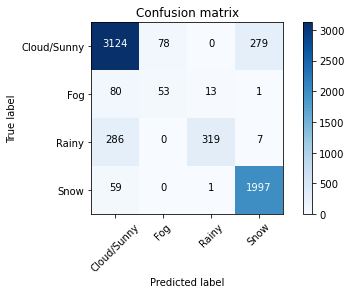

In [11]:
plot_confusion_matrix(confuse_matrix, label_list, normalize=False)